# Batch calibration & simulation

First create artificial returns from simple surrogate order-flow and the HDIM2 model. Then try to recover the kernels again and to predict the return using several different models.
You might need to `pip install matplotlib colorednoise` if you didn't install all of these optional packages yet.

In [1]:
# set the backend
import matplotlib
matplotlib.use('nbagg') # set plotting backend
import matplotlib.pyplot as plt
plt.ion()

# standard packages
import numpy as np
import pandas as pd

# included noise generator
from colorednoise import powerlaw_psd_gaussian

# propagator models
import priceprop as prop
import priceprop.batch as pb
import scorr

### Generate power-law correlated order-flow
Cross-correlations e.g. from returns to later signs are neglected. The purpose here is to demonstrate the model calibration and not to generate the most realistic order-flows possible. 

In [38]:
# autocorrelation exponents
gamma_s = 0.5   # ... of the signs
gamma_c = 0.25  # ... of the price-change indicator
# time steps to simulate
steps = 10**5 # 10**4 already gives usable results

In [39]:
# signs
s = np.sign(powerlaw_psd_gaussian(1-gamma_s, steps)).astype(int)
# change indicator
c = (powerlaw_psd_gaussian(1-gamma_c, steps) > 0)

In [40]:
# simulate HDIM2 model as "ground truth"
# ---------------------------------------------

# maximum lag for propagator kernel
maxlag = 2**8
lags = np.arange(1,maxlag+1)

# time steps
t = np.arange(steps, dtype=int)

# some power law kernels
k_n = prop.k_pow(maxlag+1, prop.beta_from_gamma(gamma_s)) * 0.25
k_c = prop.k_pow(maxlag+1, prop.beta_from_gamma(gamma_s))
k_n[0] = 0
k_n[1] = .1

r = prop.hdim2(s, c, k_n, k_c)

Create a dataframe that resembles the way actual trading data may be analysed

In [41]:
# simulate split over different days
mean_day_length = 2**8
trades = pd.DataFrame({
    'r1':         r,  # one-step mid-return
    'sign':       s,  # sign of a single trade (buy: 1, sell: -1) 
    'change':     c,  # change indicator
    # simulate days of different lenghts
    'date':       np.cumsum(np.random.rand(len(c)) / mean_day_length).astype(int)
})
# split in two sample groups for out-of-sample analysis
trades['sample'] = trades['date'] % 2

In [42]:
trades.head()

,change,date,r1,sign,sample
0,False,0,-0.000000,-1,0
1,True,0,-1.100000,-1,0
2,True,0,-0.820631,-1,0
3,True,0,-0.746653,-1,0
4,True,0,-0.697515,-1,0


Now the trades are added to a dictionary which allows to collect also the price responses, correlation matrices, etc. for later analyses.

In [43]:
db = {'tt': trades} # tt stands for true trades, i.e. after merging transactions

### Calibrate and simulate the models

In [44]:
%%time
pb.calc_models(db, nfft='pad > 300', group=True, calibrate=True, split_by='sample')
# nfft options from fast to precise: 'crop', 'pad', 'demix'
# the addition '> 300' specifies to drop groups with fewer than 300 events
# feedback can be obtained using Python's logging module.

CPU times: user 24.5 s, sys: 1.39 s, total: 25.8 s
Wall time: 25.8 s


In [45]:
# A calibration dict 'cal' was added to db. 
# It includes one key for each of the sample groups 
# (based on the column "samples" created above)
print "Calibration completed for the following sample groups:",
print db['cal'].keys()

Calibration completed for the following sample groups: [0, 1]


In [46]:
# the simulated time-series should now be included in the trades dataframe
db['tt'].head()

,change,date,r1,sign,sample,sc,sn,r_cs,r_tim1,r_tim2,r_hdim2,r_hdim2_x2
0,False,0,-0.000000,-1,0,0,-1,-0.0,-0.474052,-0.016009,0.000000,-0.000000
1,True,0,-1.100000,-1,0,-1,0,-1.0,-0.436905,-1.016212,-1.098875,-1.017821
2,True,0,-0.820631,-1,0,-1,0,-1.0,-0.410442,-0.867935,-0.819310,-0.868948
3,True,0,-0.746653,-1,0,-1,0,-1.0,-0.391056,-0.813019,-0.745930,-0.814258
4,True,0,-0.697515,-1,0,-1,0,-1.0,-0.380138,-0.788746,-0.698640,-0.789885


### Plot fitted model kernels

<IPython.core.display.Javascript object>


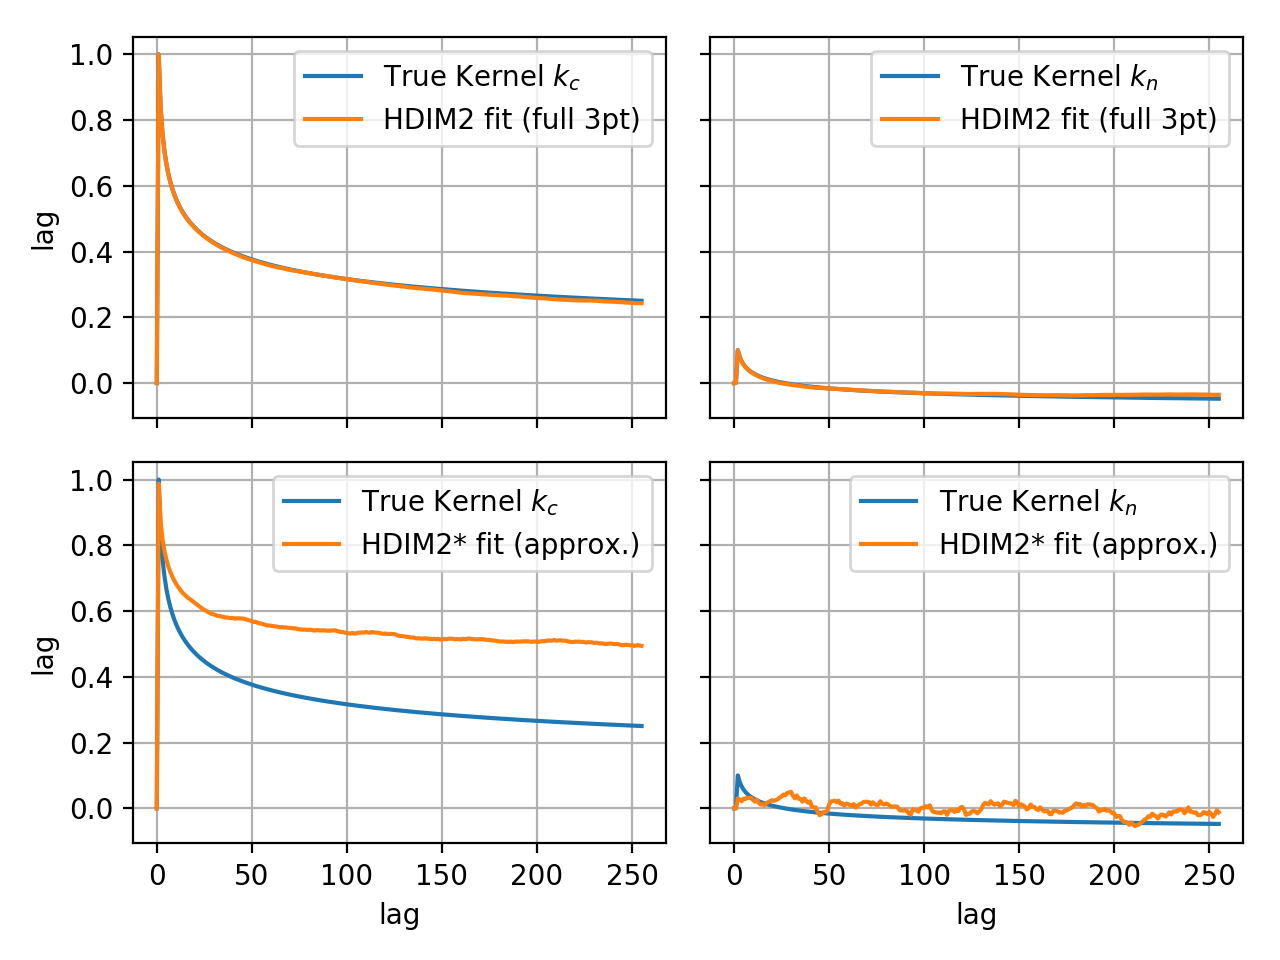

In [50]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

sample = 1 # choose of the keys listed above
fn = prop.integrate # show integrated kernels

ax[0,0].plot(fn(k_c), label='True Kernel $k_c$')
ax[0,0].plot(fn(db['cal'][sample]['kc']), label='HDIM2 fit (full 3pt)')
ax[0,0].legend()

ax[0,1].plot(fn(k_n), label='True Kernel $k_n$')
ax[0,1].plot(fn(db['cal'][sample]['kn']), label='HDIM2 fit (full 3pt)')
ax[0,1].legend()


ax[1,0].plot(fn(k_c), label='True Kernel $k_c$')
ax[1,0].plot(fn(db['cal'][sample]['kc_x2']), label='HDIM2* fit (approx.)')
ax[1,0].legend()

ax[1,1].plot(fn(k_n), label='True Kernel $k_n$')
ax[1,1].plot(fn(db['cal'][sample]['kn_x2']), label='HDIM2* fit (approx.)')
ax[1,1].legend()

# optimise
for a in ax[:,0]:
    a.set_ylabel('lag')
for a in ax[-1,:]:
    a.set_xlabel('lag')
for a in ax.flatten():
    a.grid(True)

plt.tight_layout()

### Plot the original "true" returns and those predicted from the fitted models

<IPython.core.display.Javascript object>


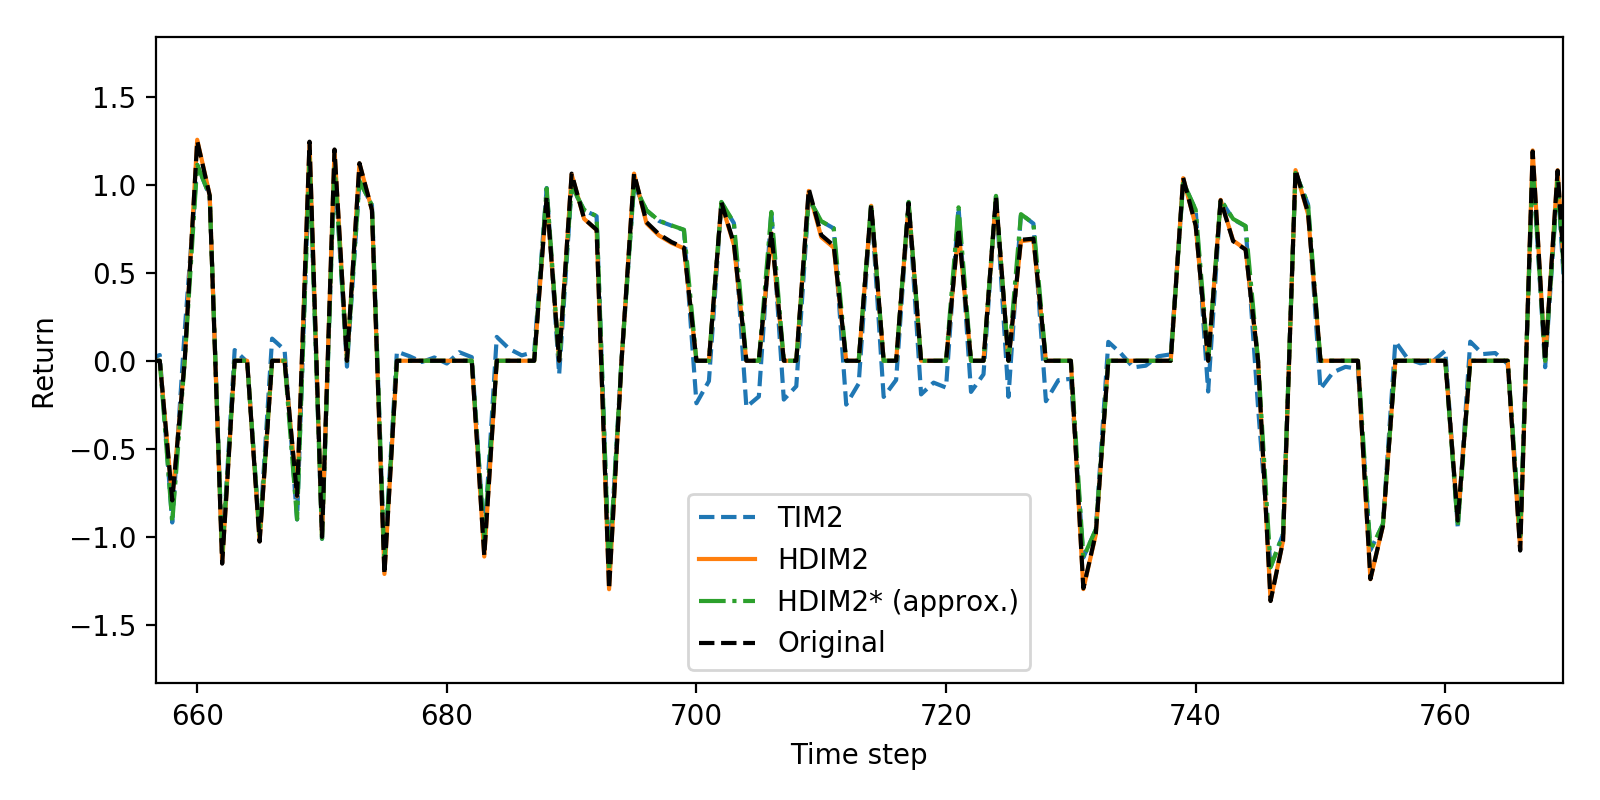

In [51]:
plt.figure(2, figsize=(8,4))
ax = plt.gca()

# choose a range between 0 and steps for the plot.
plot_start = 0
plot_end   = 1000
# plot the following predicted returns from these fitted models
# (un)comment lines to (de)select models
plot_models = [
    #'r_cim',
    #'r_tim1',
    'r_tim2',
    'r_hdim2',    # HDIM2 with full calibration
    'r_hdim2_x2' # HDIM2 with two-point approximation
]


# plot diverse models
rename_models = {
    i : i.upper().replace('R_','').replace('_X2','* (approx.)')
    for i in plot_models
}
styles = ['--','-','-.']
predicted_returns = (
    trades.iloc[plot_start:plot_end][plot_models]
    .rename(columns=rename_models)
)
predicted_returns.plot(style=styles,ax=ax)

# original returns
original_returns = trades.iloc[plot_start:plot_end][['r1']]
original_returns.columns = ['Original']
original_returns.plot(style='k--', ax=ax, )

# indicate date changes - there should be larger errors just at the beginning of a new day
plt.vlines(
    np.where(np.diff(trades['date'][plot_start:plot_end]))[0], 
    -2, 2, 
    linestyles=':', colors='#999999'
)

# format
ax.set_xlabel('Time step')
ax.set_ylabel('Return')
plt.tight_layout()

Zooming into the time series reveals that the HDIM2 is perfectly predicted using the correct calibration, but not as well using the approximate calibration or the TIM2.